# Multivariate time series forecasting using 1D convolution  
**Authors:** Konrad Maciejczyk (276927), Robert Walery (249000), Katarzyna Czak (254752)  
Wrocław University of Science and Technology, 2023-2024  

**Dataset:** [Stock Exchange Data](https://www.kaggle.com/code/alexisbcook/deep-reinforcement-learning)  

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

2024-01-07 19:18:01.878340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 19:18:01.903908: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 19:18:01.904592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 19:18:02.403061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data loading and preprocessing

In [2]:
stock_df = pd.read_csv('indexData.csv')
stock_NYA_df = stock_df[stock_df['Index'] == 'NYA'].dropna()
stock_NYA_df.drop(['Index', 'Date', 'Volume'], axis='columns', inplace=True)
stock_NYA_df

stock_NYA_df = stock_NYA_df
stock_NYA_df

,Open,High,Low,Close,Adj Close
0,528.690002,528.690002,528.690002,528.690002,528.690002
1,527.210022,527.210022,527.210022,527.210022,527.210022
2,527.840027,527.840027,527.840027,527.840027,527.840027
3,531.119995,531.119995,531.119995,531.119995,531.119995
4,532.070007,532.070007,532.070007,532.070007,532.070007
...,...,...,...,...,...
13943,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450
13944,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450
13945,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940
13946,16451.960940,16546.359380,16451.960940,16531.949220,16531.949220


In [3]:
WINDOW_SIZE = 5
FEATURE_SIZE = stock_NYA_df.shape[1]

def df_to_X_y(df, window_size = 6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [4]:
X, y = df_to_X_y(stock_NYA_df, window_size = WINDOW_SIZE)
X.shape, y.shape

((13942, 5, 5), (13942,))

## Splitting data into training, validating and testing datasets

In [5]:
train_len = int(stock_NYA_df.shape[0] * 0.6)
test_val_len = int(stock_NYA_df.shape[0] * 0.2)

X_train, y_train = X[:train_len], y[:train_len]
X_val, y_val = X[train_len: train_len + test_val_len], y[train_len: train_len + test_val_len]
X_test, y_test = X[train_len + test_val_len: train_len + (test_val_len * 2)], y[train_len + test_val_len: train_len + (test_val_len * 2)]

print(f'Training dataset size: {X_train.shape}')
print(f'Testing dataset size: {X_test.shape}')
print(f'Validation dataset size: {X_val.shape}')

Training dataset size: (8368, 5, 5)
Testing dataset size: (2785, 5, 5)
Validation dataset size: (2789, 5, 5)


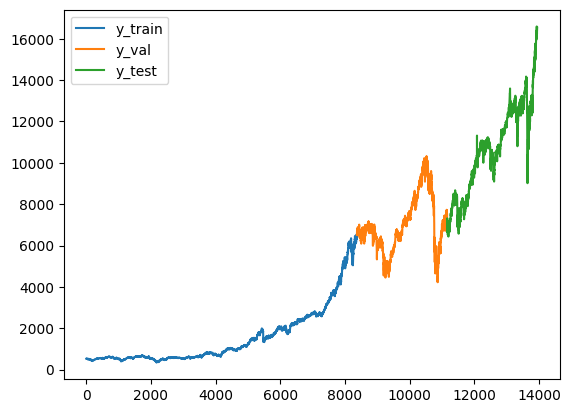

In [8]:
a = y_train.shape[0]
plt.plot([_ for _ in range(a)], y_train, label = 'y_train')
a, b= y_train.shape[0], y_train.shape[0] + y_val.shape[0]
plt.plot([_ for _ in range(a, b)], y_val, label = 'y_val')
a, b = y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]
plt.plot([_ for _ in range(a, b)], y_test, label = 'y_test')
plt.legend()
plt.show()

## Model architecture  

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer((WINDOW_SIZE, FEATURE_SIZE)))
model.add(tf.keras.layers.Conv1D(64, kernel_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8, 'relu'))
model.add(tf.keras.layers.Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             704       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 8)                 2056      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,769
Trainable params: 2,769
Non-trainable params: 0
_________________________________________________________________


2024-01-07 19:19:36.514893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 19:19:36.515197: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['mse'])

In [11]:
X_val.shape
X_train.shape

(8368, 5, 5)

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
262/262 [==============================] - 1s 2ms/step - loss: 42808.5469 - mse: 42808.5469 - val_loss: 9455.2754 - val_mse: 9455.2754
Epoch 2/10
262/262 [==============================] - 0s 1ms/step - loss: 891.6106 - mse: 891.6106 - val_loss: 9495.5996 - val_mse: 9495.5996
Epoch 3/10
262/262 [==============================] - 0s 1ms/step - loss: 890.2634 - mse: 890.2634 - val_loss: 9596.1436 - val_mse: 9596.1436
Epoch 4/10
262/262 [==============================] - 0s 1ms/step - loss: 892.0753 - mse: 892.0753 - val_loss: 9300.3711 - val_mse: 9300.3711
Epoch 5/10
262/262 [==============================] - 0s 1ms/step - loss: 872.3644 - mse: 872.3644 - val_loss: 9052.5732 - val_mse: 9052.5732
Epoch 6/10
262/262 [==============================] - 0s 1ms/step - loss: 871.8267 - mse: 871.8267 - val_loss: 9286.4629 - val_mse: 9286.4629
Epoch 7/10
262/262 [==============================] - 0s 1ms/step - loss: 881.1154 - mse: 881.1154 - val_loss: 9135.2559 - val_mse: 9135.2559
Ep

In [17]:
pred = model.predict(X_test)

88/88 [==============================] - 0s 630us/step


[]

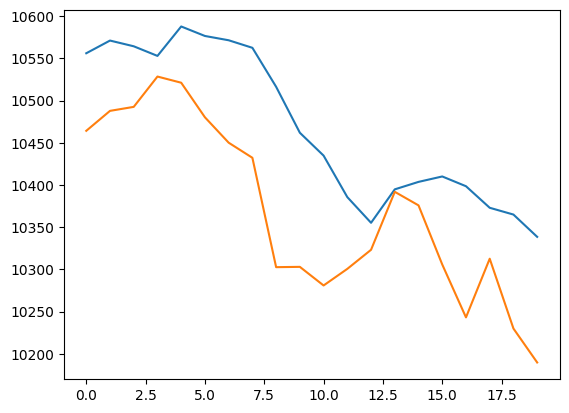

In [23]:
plt.plot([_ for _ in range(20)], pred[1500:1520])
plt.plot([_ for _ in range(20)], y_test[1500:1520])
plt.plot()